In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from math import isnan

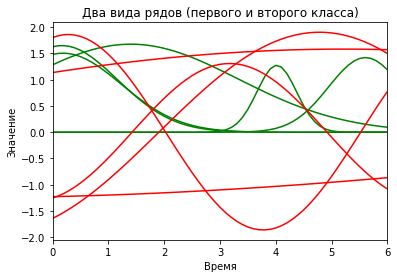

data.shape = (12200, 4)
data.id.nunique() = 200


,t,y,label,id
0,0.0,1.957849,1,0
1,0.1,1.957849,1,0
2,0.2,1.957849,1,0


In [2]:
N = 100 ## количество семплов каждого класса
Nvis = 5 ## сколько семплов будем визуализировать
timePoints = 61  ## количество элементов в каждом из рядов

df = pd.DataFrame()
data = pd.DataFrame()
t = np.linspace(0, 6, timePoints) 

random.seed(42)

## генерируем семплы первого класса
for i in range(N):
    t0 = 2*np.pi*random.random()
    a1 = 5*random.random()
    A = 1 + random.random()        
    
    df['t']  = t                   ## ось времени
    df['y']  = A*np.exp(-(df.t-t0)**2/2/a1)  ## значения временного ряда
    df['label'] = 1                ## класс временного ряда 
    df['id'] = i                   ## номер временного ряда
    
    data = data.append(df)         ## добавляем семпл в общий дейтафрейм
    if i < Nvis:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='g') 
    
## генерируем семплы второго класса    
for i in range(N, 2*N):
    A = 1 + random.random()          ## амплитуда
    w = 0 + random.random()          ## частота
    ph = 2*np.pi * random.random()   ## фаза
    
    df['t']  = t                     ## ось времени
    df['y']  = A*np.sin(t*w + ph)    ## значения временного ряда
    df['label'] = 0                  ## класс временного ряда 
    df['id'] = i                     ## номер временного ряда
    
    data = data.append(df)           ## добавляем семпл в общий дейтафрейм
    if i < Nvis+N:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='r') 
    
## cдвигаем все значения вверх, чтобы все значения были положительными    
data['y'] = data.y + np.abs(data.y.min())
    
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title('Два вида рядов (первого и второго класса)')
plt.xlim([t[0], t[-1]])
plt.show()

print('data.shape =', data.shape)
print('data.id.nunique() =', data.id.nunique())
data.head(3)

In [4]:
data.id.value_counts()

0      61
101    61
21     61
29     61
37     61
       ..
154    61
162    61
170    61
178    61
199    61
Name: id, Length: 200, dtype: int64

In [67]:
features = pd.DataFrame()

In [68]:
features[['label', 'min']] = data.groupby('id')[['label', 'y']].min()


In [69]:
features['mean'] = data.groupby('id')['y'].mean()
features['median'] = data.groupby('id')['y'].median()

In [70]:
features.sample(5)

,label,min,mean,median
id,,,,
18,1,2.034864,2.682196,2.756000
192,0,0.419712,1.059393,0.813688
1,1,2.052910,2.972939,3.143508
24,1,1.957958,2.527559,2.182717
22,1,1.957849,2.174387,1.958515


In [72]:
features = features.reset_index()

In [73]:
features.sample(5)

,id,label,min,mean,median
94,94,1,1.961482,2.635066,2.581836
183,183,0,0.881926,1.840540,1.670576
106,106,0,0.803447,2.072110,2.155639
177,177,0,0.288590,2.034723,2.091551
142,142,0,0.301822,0.302297,0.302218


trainSet.shape = (120, 5)
testSet.shape  = (80, 5)

Value counts train:
 0    60
1    60
Name: label, dtype: int64

Value counts test:
 0    40
1    40
Name: label, dtype: int64


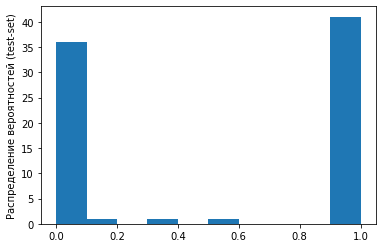

  features  importances
0      min     0.990347
2   median     0.007366
1     mean     0.002287

   Pos  Neg
0   38    2
1    0   40

AUC = 0.987  Точность = 0.975

<ipython-input-76-32a092e08adf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['pred'] = y_pred
<ipython-input-76-32a092e08adf>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['pred_proba'] = y_pred_proba


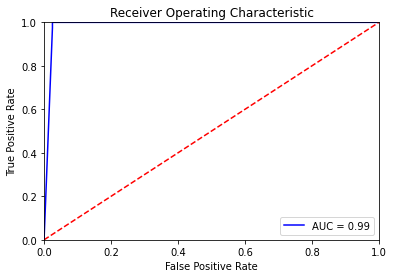

In [76]:
trainSet, testSet = train_test_split(features, test_size=0.4, random_state=42) 

## выводим статистику по нашим наборам
print('trainSet.shape =', trainSet.shape)
print('testSet.shape  =', testSet.shape)
print()
print('Value counts train:\n', trainSet.label.value_counts())
print()
print('Value counts test:\n', testSet.label.value_counts())

## лист фич
featureList = trainSet.drop(['id', 'label'], axis=1).columns

## параметры классификатора
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2, 'max_features' : 1.0, 'class_weight' : 'balanced',
         'random_state': 42}

## обучаем классификатор
clf = RandomForestClassifier(**params).fit(trainSet[featureList], trainSet['label'])

## делаем предсказание на тестовом наборе
y_pred = clf.predict(testSet[featureList])
y_pred_proba = clf.predict_proba(testSet[featureList])[:, 1]  ## вероятности

## визуализируем вероятности для предсказаний
plt.hist(y_pred_proba)
plt.ylabel('Распределение вероятностей (test-set)')
plt.show()
## создадим для удобства дейтафрейм с результатами
res = testSet
res['pred'] = y_pred 
res['pred_proba'] = y_pred_proba

## получаем из классификатора важность фич и отображаем их
ftmprt = pd.DataFrame()
ftmprt['features'] = featureList
ftmprt['importances'] = clf.feature_importances_
ftmprt = ftmprt.sort_values('importances', ascending=
False)
print(ftmprt.head(20))
print()
proba = res.pred_proba

## считаем матрицу ошибок
CM = confusion_matrix(res['label'], res['pred'])
CM_DF = pd.DataFrame(data=CM, columns = ['Pos', 'Neg'])
print(CM_DF)

# ROC-AUC 
FPR, TPR, thresholds = roc_curve(res['label'], res['pred_proba'])
roc_auc = auc(FPR, TPR)
acc = res[res['pred'] == res['label']].shape[0] / res.shape[0] ## точность
print(f"\nAUC = {roc_auc:.3f}  Точность = {acc:.3f}\n")

# ROC-кривая
plt.title('Receiver Operating Characteristic')
plt.plot(FPR, TPR, 'b', label=f'AUC = {roc_auc:.2f}')
plt.legend(loc=
'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [77]:
def featuresTSFresh(data):    

    ## список фич (см. документацию по TSFresh: https://media.readthedocs.org/pdf/tsfresh/latest/tsfresh.pdf)
    extraction_settings = \
    {
        ## признак: параметр
        "mean": None,
        "minimum": None,
        "median": None,
        "count_below_mean": None
        
    }

    ## извлечение фич из данных    
    featuresDF = extract_features(
        data, 
        column_id='id',  ## номер временного ряда
        column_sort='t', ## ось времени
        default_fc_parameters=extraction_settings, ## список фич, которые хотим извлечь
        impute_function=impute                     ## заменить все inf и NaN
    )
    
    ## вытаскиваем колонку id из индекса 
    featuresDF = featuresDF.reset_index()

    return featuresDF

In [78]:
DFF = featuresTSFresh(data)

Feature Extraction: 100%|██████████| 29/29 [00:00<00:00, 317.00it/s]


In [81]:
DFF.iloc[4]

index                       4.000000
y__mean                     2.354036
y__minimum                  1.957850
y__median                   1.986966
y__count_below_mean        42.000000
label__mean                 1.000000
label__minimum              1.000000
label__median               1.000000
label__count_below_mean     0.000000
Name: 4, dtype: float64